# 標高データからPyTorchで予測 GEE

In [3]:
from math import pi
from math import e, log
from math import atan, tan

def tile2longlati(x, y, z):
	long_west = (x / 2.0**z) * 360 - 180 # 西端経度
	long_east = ((x+1) / 2.0**z) * 360 - 180 # 東端経度
	map_y1 = (y / 2.0**z) * 2 * pi - pi
	map_y2 = ((y+1) / 2.0**z) * 2 * pi - pi
	lati_north = 2 * atan(e ** (- map_y1)) * 180 / pi - 90 # 北端緯度
	lati_south = 2 * atan(e ** (- map_y2)) * 180 / pi - 90 # 南端緯度
	return lati_south, long_west, lati_north, long_east #南端、西端、北端、東端

def longlati2tile(long, lati, z): #タイルの北西端の緯度経度からタイル座標を返します
	x = int((long + 180) / 360 * pow(2,z))
	y = int((-log(tan((lati + 90) * pi / 360)) + pi) / (2*pi) * (pow(2,z)))
	return x,y

In [4]:
import glob 
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms.functional as TF
from functools import lru_cache

import torch
import torchvision

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch import optim 

from tqdm.notebook import tqdm

import rasterio

# Dataset

In [2]:
def get_mask( narr, condition):
    mask = (narr[:, :, 0] == condition[0]) & (narr[:, :, 1] == condition[1]) & (narr[:, :, 2] == condition[2])
    return mask.astype(np.int32)

LABEL_CONDITIONS = [[0, 0, 0, 0],
                    [247, 245, 169, 255], 
                    [255, 216, 192, 255] , 
                    [255, 183, 183, 255],
                    [255, 145, 145, 255],
                    [242, 133, 201, 255],
                    [255, 145, 145, 255],
                    [220, 122, 220, 255],
                            ]

class ImageData(Dataset):
    
    def __init__(self, path_height, path_target):
        self.n_cat = 7
        self.path_dir_height = path_height
        self.path_dir_target = path_target
        self.pathes_heihgt = glob.glob(os.path.join(path_height, "*_*_*.png"))
        self.pathes_target = glob.glob(os.path.join(path_target, "*_*_*.png"))
        print("n pathes", len(self.pathes_heihgt),len(self.pathes_target) )
        # 共通のfile name
        self.common_file_name = set(list(map(lambda x : os.path.basename(x), self.pathes_heihgt))) & set(set(list(map(lambda x : os.path.basename(x), self.pathes_target))))
        self.common_file_name = list(self.common_file_name)
        self.common_file_name.sort()
        print(f"n commons {len(self.common_file_name)}")
        self.tranform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

        

    def __len__(self):
        return len(self.common_file_name)
        
    @lru_cache(maxsize = None)
    def __getitem__(self, idx, return_raw_y = False):             
        path_h = self.common_file_name[idx]
        im_x = np.array(Image.open(os.path.join(self.path_dir_height, path_h)).convert('RGB'))
        im_y = np.array(Image.open(os.path.join(self.path_dir_target, path_h)).convert('RGB'))
        x = np.asarray(im_x) / 255
        y= np.asarray(im_y).astype(np.int32)
        if x.shape[-1]!=3:
            x = x.reshape(x.shape[0], x.shape[1] , 3)
        y_idx = np.zeros((y.shape[0], y.shape[1])).astype(int)
        for i in range(self.n_cat):
            mask = (y[:, :, 0] == LABEL_CONDITIONS[i][0]) & (y[:, :, 1] == LABEL_CONDITIONS[i][1]) & (y[:, :, 2] == LABEL_CONDITIONS[i][2])
            y_idx[mask] = i
        if return_raw_y:
            return self.tranform(x.astype(np.float32)), self.tranform(y_idx), y , path_h 
        else :
            return self.tranform(x.astype(np.float32)), self.tranform(y_idx)


def labelidx2rgb_np(tensor):
    # tensor: c h, w 
    if len(tensor.shape)==3:
        tensor = tensor.reshape(tensor.shape[1], tensor.shape[2])
    rgb = np.zeros((tensor.shape[0],tensor.shape[1], 3)).astype(int)
    #print(tensor.shape, rgb.shape,  )
    narr = tensor.cpu().numpy().astype(int)
    for i in range(7):
        #print(narr[:10, :10])
        #print(narr.shape, (narr ==  i).shape ,  (narr ==  i).min(), (narr ==  i).max())
        rgb[:, :, 0][narr ==  i] = LABEL_CONDITIONS[i][0]
        rgb[:, :, 1][narr ==  i] = LABEL_CONDITIONS[i][1]
        rgb[:, :, 2][narr ==  i]= LABEL_CONDITIONS[i][2]
    return rgb
        

path_dir_height = "../data/GEE_download"
path_dir_target = "/content/drive/My Drive/SpaceAppsChallenge2020/data/hazard_img/洪水/関東平野/z14"
dataset = ImageData(path_dir_height, path_dir_target)



n pathes 0 0
n commons 0


* [255 145 145 255] : 3 赤 5~10mm   
*  [255 183 183 255] : 2 薄い赤 3~5mm  
* [247 245 169 255] : 0 黄色　　０．５m未満  
* [255 216 192 255] : 1 橙色 0.5~3mm  
* [0 0 0 0] : 6 黒　不明  
* [242 133 201 255] : 4 うす紫 10~20mm  

torch.Size([3, 256, 256]) torch.Size([1, 256, 256])
tensor(0.9843)


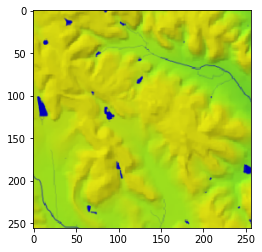

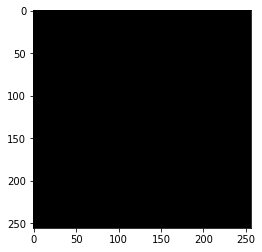

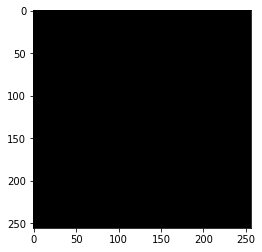

0 0
diff
0 0


'\nplt.imshow(data0[2] - im_rgb)\nplt.show()\n\narr = np.transpose(data0[1].numpy(),  (1, 2, 0))\nfor i in  range(arr.shape[-1]):\n    plt.imshow(arr[:,:,i])\n    plt.show()\n'

In [3]:
data0 = dataset.__getitem__(190, return_raw_y=True)
print(data0[0].shape, data0[1].shape,)
print(data0[0].max())

plt.imshow(np.transpose(data0[0].numpy(), (1,2,0)))
plt.show()

plt.imshow(data0[2])
plt.show()
im_rgb =  labelidx2rgb_np(data0[1])
plt.imshow(im_rgb)
plt.show()
print(im_rgb.max(), im_rgb.min())
print("diff")
print((data0[2] - im_rgb).max(), (data0[2] - im_rgb).min())
"""
plt.imshow(data0[2] - im_rgb)
plt.show()

arr = np.transpose(data0[1].numpy(),  (1, 2, 0))
for i in  range(arr.shape[-1]):
    plt.imshow(arr[:,:,i])
    plt.show()
"""

In [4]:
# shuffleしてから分割してくれる.
whole_size = int(dataset.__len__() * 0.7)
indexes =  np.arange(whole_size)
np.random.shuffle(indexes)

train_size = int(0.6 * whole_size)
val_size =int(0.2 * whole_size)
test_size =  whole_size - train_size - val_size
print(f"data size: train = {train_size}, val={val_size}, test={test_size}")
train_dataset= torch.utils.data.Subset(dataset, indexes[:train_size])
val_dataset= torch.utils.data.Subset(dataset, indexes[train_size:train_size + val_size])
test_dataset= torch.utils.data.Subset(dataset, indexes[-test_size:])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(train_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(train_dataset, batch_size=16, shuffle=False)



data size: train = 958, val=319, test=321


# model

In [5]:
def conv1x1(in_channels, out_channels, groups=1):
    return nn.Conv2d(in_channels,
                     out_channels,
                     kernel_size=1,
                     groups=groups,
                     stride=1)

def conv3x3(in_channels, out_channels, stride=1, padding=1, bias=True, groups=1):
    return nn.Conv2d(in_channels,
                     out_channels,
                     kernel_size=3,
                     stride=stride,
                     padding=padding,
                     bias=bias,
                     groups=groups)

def upconv2x2(in_channels, out_channels, mode='transpose'):
    if mode == 'transpose':
        return nn.ConvTranspose2d(in_channels,
                                  out_channels,
                                  kernel_size=2,
                                  stride=2)
    else:
        return nn.Sequential(
            nn.Upsample(mode='bilinear', scale_factor=2),
            conv1x1(in_channels, out_channels))
class DownConv(nn.Module):
    """
    A helper Module that performs 2 convolutions and 1 MaxPool.
    A ReLU activation follows each convolution.
    """
    def __init__(self, in_channels, out_channels, pooling=True):
        super(DownConv, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.pooling = pooling

        self.conv1 = conv3x3(self.in_channels, self.out_channels)
        self.conv2 = conv3x3(self.out_channels, self.out_channels)

        if self.pooling:
            self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        before_pool = x
        if self.pooling:
            x = self.pool(x)
        return x, before_pool

class UpConv(nn.Module):
    """
    A helper Module that performs 2 convolutions and 1 UpConvolution.
    A ReLU activation follows each convolution.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 merge_mode='concat',
                 up_mode='transpose'):
        super(UpConv, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.merge_mode = merge_mode
        self.up_mode = up_mode

        self.upconv = upconv2x2(self.in_channels,
                                self.out_channels,
                                mode=self.up_mode)

        if self.merge_mode == 'concat':
            self.conv1 = conv3x3(2*self.out_channels,
                                 self.out_channels)
        else:
            # num of input channels to conv2 is same
            self.conv1 = conv3x3(self.out_channels, self.out_channels)

        self.conv2 = conv3x3(self.out_channels, self.out_channels)

    def forward(self, from_down, from_up):
        """ Forward pass
        Arguments:
            from_down: tensor from the encoder pathway
            from_up: upconv'd tensor from the decoder pathway
        """
        from_up = self.upconv(from_up)
        if self.merge_mode == 'concat':
            x = torch.cat((from_up, from_down), 1)
        else:
            x = from_up + from_down
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        return x
class UNet(nn.Module):
    """ `UNet` class is based on https://arxiv.org/abs/1505.04597
    The U-Net is a convolutional encoder-decoder neural network.
    Contextual spatial information (from the decoding,
    expansive pathway) about an input tensor is merged with
    information representing the localization of details
    (from the encoding, compressive pathway).
    Modifications to the original paper:
    (1) padding is used in 3x3 convolutions to prevent loss
        of border pixels
    (2) merging outputs does not require cropping due to (1)
    (3) residual connections can be used by specifying
        UNet(merge_mode='add')
    (4) if non-parametric upsampling is used in the decoder
        pathway (specified by upmode='upsample'), then an
        additional 1x1 2d convolution occurs after upsampling
        to reduce channel dimensionality by a factor of 2.
        This channel halving happens with the convolution in
        the tranpose convolution (specified by upmode='transpose')
    """

    def __init__(self, num_classes, in_channels=3, depth=5,
                 start_filts=64, up_mode='transpose',
                 merge_mode='concat'):
        """
        Arguments:
            in_channels: int, number of channels in the input tensor.
                Default is 3 for RGB images.
            depth: int, number of MaxPools in the U-Net.
            start_filts: int, number of convolutional filters for the
                first conv.
            up_mode: string, type of upconvolution. Choices: 'transpose'
                for transpose convolution or 'upsample' for nearest neighbour
                upsampling.
        """
        super(UNet, self).__init__()

        if up_mode in ('transpose', 'upsample'):
            self.up_mode = up_mode
        else:
            raise ValueError("\"{}\" is not a valid mode for "
                             "upsampling. Only \"transpose\" and "
                             "\"upsample\" are allowed.".format(up_mode))

        if merge_mode in ('concat', 'add'):
            self.merge_mode = merge_mode
        else:
            raise ValueError("\"{}\" is not a valid mode for"
                             "merging up and down paths. "
                             "Only \"concat\" and "
                             "\"add\" are allowed.".format(up_mode))

        # NOTE: up_mode 'upsample' is incompatible with merge_mode 'add'
        if self.up_mode == 'upsample' and self.merge_mode == 'add':
            raise ValueError("up_mode \"upsample\" is incompatible "
                             "with merge_mode \"add\" at the moment "
                             "because it doesn't make sense to use "
                             "nearest neighbour to reduce "
                             "depth channels (by half).")

        self.num_classes = num_classes
        self.in_channels = in_channels
        self.start_filts = start_filts
        self.depth = depth

        self.down_convs = []
        self.up_convs = []

        # create the encoder pathway and add to a list
        for i in range(depth):
            ins = self.in_channels if i == 0 else outs
            outs = self.start_filts*(2**i)
            pooling = True if i < depth-1 else False

            down_conv = DownConv(ins, outs, pooling=pooling)
            self.down_convs.append(down_conv)

        # create the decoder pathway and add to a list
        # - careful! decoding only requires depth-1 blocks
        for i in range(depth-1):
            ins = outs
            outs = ins // 2
            up_conv = UpConv(ins, outs, up_mode=up_mode,
                merge_mode=merge_mode)
            self.up_convs.append(up_conv)

        self.conv_final = conv1x1(outs, self.num_classes)

        # add the list of modules to current module
        self.down_convs = nn.ModuleList(self.down_convs)
        self.up_convs = nn.ModuleList(self.up_convs)

        self.reset_params()

    @staticmethod
    def weight_init(m):
        if isinstance(m, nn.Conv2d):
            nn.init.xavier_normal(m.weight)
            nn.init.constant(m.bias, 0)


    def reset_params(self):
        for i, m in enumerate(self.modules()):
            self.weight_init(m)

    def forward(self, x):
        encoder_outs = []

        # encoder pathway, save outputs for merging
        for i, module in enumerate(self.down_convs):
            x, before_pool = module(x)
            encoder_outs.append(before_pool)

        for i, module in enumerate(self.up_convs):
            before_pool = encoder_outs[-(i+2)]
            x = module(before_pool, x)

        # No softmax is used. This means you need to use
        # nn.CrossEntropyLoss is your training script,
        # as this module includes a softmax already.
        x = self.conv_final(x)
        return x

        
# https://qiita.com/4Ui_iUrz1/items/4c0efd9c50e344c66665
class CEDiceLoss(nn.Module):
    def __init__(self):
        super(CEDiceLoss, self).__init__()

    def forward(self, input, target):
        n_class= input.shape[1]
        input = input.permute(0, 2, 3, 1).reshape(-1 , n_class) # n c h w -> n*h*w c
        target = target.reshape(-1) # n h w -> n*h*w 
        bce = F.cross_entropy(input, target)
        smooth = 1e-5
        input = torch.sigmoid(input)
        num = target.size(0)
        input = input.view(num, -1)
        target = target.view(num, -1)
        intersection = (input * target)
        dice = (2. * intersection.sum(1) + smooth) / (input.sum(1) + target.sum(1) + smooth)
        dice = 1 - dice.sum() / num
        return 0.5 * bce + dice

class CELoss(nn.Module):
    def __init__(self, weight=None):
        super(CELoss, self).__init__()
        self.weight  = weight
        self.cross_entropy = nn.CrossEntropyLoss(weight=self.weight)

    def forward(self, input, target):
        n_class= input.shape[1]
        input = input.permute(0, 2, 3, 1).reshape(-1 , n_class) # n c h w -> n*h*w c
        target = target.reshape(-1) # n h w -> n*h*w 
        bce = self.cross_entropy(input, target)
        return  bce

# Train

In [6]:
def iou_score(output, target):
    smooth = 1e-5

    if torch.is_tensor(output):
        output = torch.sigmoid(output).data.cpu().numpy()
    if torch.is_tensor(target):
        target = target.data.cpu().numpy()
    output = output > 0.5
    target = target > 0.5
    intersection = (output & target).sum()
    union = (output | target).sum()

    return (intersection + smooth) / (union + smooth)


def logit2labelidx(tensor):
    # tensor (c, h, w) (7, 257, 256)
    # tensor = F.softmax(torch.sigmoid(tensor), dim=0)
    print(tensor.shape)
    idx_max = torch.argmax(tensor, dim=0)
    return idx_max

# debug
labeidx = logit2labelidx(torch.randn(7, 256, 256).cpu())
print(labeidx .shape)
print(labeidx [:4, :4])


torch.Size([7, 256, 256])
torch.Size([256, 256])
tensor([[5, 6, 2, 4],
        [0, 1, 3, 6],
        [5, 6, 4, 1],
        [6, 6, 1, 4]])


In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model  = UNet(num_classes=7, in_channels=3, depth=5,
                 start_filts=64, up_mode='transpose',
                 merge_mode='concat').to(device)

optimizer = optim.Adam(model.parameters())
weight= torch.from_numpy(np.logspace(0, 1, 7).astype(np.float32)).to(device)
criterion = CELoss(weight=weight)
epoch = 10

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:194: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:195: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.


In [8]:
!nvidia-smi

Sun Oct  4 11:55:33 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    32W / 250W |    927MiB / 16280MiB |      9%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [9]:
# パラメータカウント
params = 0
for p in model.parameters():
    if p.requires_grad:
        params += p.numel()
        
print("number of trainable parameters: ", params) 

number of trainable parameters:  31032135


In [ ]:
losses_train = []
losses_val = []


for epo in range(1 , epoch+1):
    print(f"{epo} th epoch...", end="")
    
    # train
    loss_running = []
    model.train()
    for batch in tqdm(train_loader):
        X, y = batch[0], batch[1]
        optimizer.zero_grad()
        logit = model(X.to(device))
        loss = criterion( logit, y.to(device)).to(device)
        loss.backward()
        optimizer.step()
        loss_running.append(float(loss.detach().item()))
    losses_train.append(np.mean(loss_running))
    print(f"loss train: {losses_train[-1]}", end=" ")

    # valid
    loss_running = []
    model.eval()
    with torch.no_grad():
        for batch in tqdm(val_loader):
            X, y = batch[0], batch[1]
            logit = model(X.to(device))
            loss = criterion( logit, y.to(device)) 
            loss_running.append(float(loss.detach().item()))
    losses_val.append(np.mean(loss_running))
    print(f"loss val: {losses_val[-1]}")

    if min(losses_val) == losses_val[-1]:
        torch.save(model.state_dict(), os.path.join("/content/drive/My Drive/SpaceAppsChallenge2020/weights",'best-model-parameters_CE_digital_height_v1.pt'))

# testM
loss_running = []
model.eval()
with torch.no_grad():
    for batch in tqdm(test_loader):
        X, y = batch[0], batch[1]
        logit = model(X.to(device))
        loss = criterion( logit, y.to(device)) 
        #score = iou_score(logit, y.to(device))
print(f"loss test: {loss.detach().item()}")

1 th epoch...


loss train: 3.939170906941096 


loss val: 1.4466323633988698
2 th epoch...


loss train: 1.378308077653249 


loss val: 1.3510836044947305
3 th epoch...


loss train: 1.3360100090503693 


loss val: 1.318170221646627
4 th epoch...


loss train: 1.3234774351119996 


loss val: 1.3282842338085175
5 th epoch...


loss train: 1.326000847419103 


loss val: 1.3049491047859192
6 th epoch...


loss train: 1.3133296926816305 


loss val: 1.3310737609863281
7 th epoch...


loss train: 1.3036726494630178 


loss val: 1.3038396378358206
8 th epoch...


loss train: 1.3025451004505157 


loss val: 1.3109574099381764
9 th epoch...


loss train: 1.310693621635437 


loss val: 1.2962129632631938
10 th epoch...

In [ ]:
plt.plot(np.arange(len(losses_train)), losses_train, label= "train")
plt.plot(np.arange(len(losses_val)), losses_val, label= "val")
plt.xlabel("epoch")
plt.legend()
plt.show()

# 検証

 ## 可視化

In [ ]:
def plot_result(predict, target, save_path=None):
    # input must be 2 np.arry (h w, 3)
    size=8
    figure, ax = plt.subplots( 1, 2, figsize=(size, size*2))
    for i, (name, im) in enumerate(zip(["predict", "true"], [predict, target])):
        ax[i].imshow(im)
        ax[i].set_title(name)
    plt.legend()
    if save_path:
        plt.savefig(save_path)
    plt.show()
        

In [ ]:
loss_running = []
model.eval()
n_show = 300
c=0
for j in tqdm(range(test_loader.dataset.__len__())):
    batch = test_loader.dataset.dataset.__getitem__(j,  return_raw_y=True)
    X, y = batch[0].unsqueeze(0), batch[1]          
    for i in range(X.shape[0]):
        with torch.no_grad():
            logit = model(X.to(device)).detach().cpu()
        y_predict=labelidx2rgb_np(logit2labelidx(logit[i]))
        y_true = y[i].cpu()
        #print(y_predict[: , 23 ,54])
        # plt.imshow(torch.sigmoid(logit[i]).cpu().numpy().transpose(1, 2, 0)[:,:,-1] > 0.4)
        y_true_plot = labelidx2rgb_np(y_true)
        if y_true_plot.max() > 10:
            name_file =batch[-1].split(".")[0] 
            print(name_file)
            save_path = os.path.join("/content/drive/My Drive/SpaceAppsChallenge2020/画像/国土地理院標高デジタル_洪水", f"pair_image_{name_file}.png")
            plot_result(y_predict, y_true_plot, )
            c  +=1
        if c > n_show:
            break
    if c> n_show:
        break